# 8. `xarray`繪圖 (1)：繪製1D資料

能開啟資料、進行資料分析和統計後，接著要用清晰的圖示來表現計算的結果。而用`xarray`繪圖非常簡單，將計算的結果儲存成DataArray和Dataset後，有內建的plot method可以運用。各種繪圖的方法總結如下，並且可以點進連結查詢各引數之詳細說明。

**單變數資料：** `xarray.DataArray.plot`
* 1D - 時序圖、折線圖 (Line plot) [`xarray.DataArray.plot.line`](http://xarray.pydata.org/en/stable/generated/xarray.plot.line.html#xarray.plot.line)。
* 1D - 直方圖 (Histogram) [`xarray.DataArray.plot.hist`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.hist.html?highlight=hist)。
* 1D - 階梯圖 (Step plot) [`xarray.DataArray.plot.step`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.step.html)。
* 2D - 等值色階圖 (網狀方格) [`xarray.DataArray.plot.pcolormesh`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.pcolormesh.html?highlight=pcolormesh)。
* 2D - 等值色階圖 [`xarray.DataArray.plot.contourf`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.contourf.html)。
* 2D - 等值線圖 [`xarray.DataArray.plot.contour`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.contour.html)。
* 2D - 等值面圖 (繪製在3維空間上) [`xarray.DataArray.plot.surface`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.surface.html)。
* 3D、4D - 將以上的圖組合在一起，稱為Facet Grid Object，在以上的函數中可以利用`row`、`col`等引數來設定。

**多變數資料：** `xarray.Dataset.plot`
* 散布圖 (scatter plot) 由於是評估兩變數之間的關係，因此兩變數也要存成Dataset來繪製 [`xarray.Dataset.plot.scatter`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.plot.scatter.html?highlight=dataset%20scatter)。
* 風場 (Quiver plot) [`xarray.Dataset.plot.quiver`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.plot.scatter.html?highlight=dataset%20scatter)。
* 流線 (Streamplot) [`xarray.Dataset.plot.streamplot`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.plot.streamplot.html)。

xarray的函數都包裝了matplotlib的繪圖功能，因此只要是matplotlib使用到的引數，在`xarray.plot`的方法中也都可以引用 (即**kwargs  – Additional keyword arguments to wrapped Matplotlib function.)。

## 繪製時序圖 (time series)

利用 [`xarray.DataArray.plot.line`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.line.html)就可以直接繪製，xarray官網上就有很清楚的範例。不過在這單元我們會補充一些進階用法。

### Fill-between

**Example 1:** 繪製台灣－北南海區域 (18˚-24N, 116˚-126˚E) 降雨的候時間序列，其中以灰色的陰影代表氣候上的最大、最小值，粗黑線代表氣候上的中位數。

In [1]:
import xarray as xr 
from matplotlib import pyplot as plt
import pandas as pd 
import matplotlib as mpl
from matplotlib import ticker

mpl.rcParams['figure.dpi'] = 100

lats = 18          
latn = 24          
lon1 = 116         
lon2 = 126 
ys = 1998
ye = 2020

plt.rcParams.update({'font.size': 14})

def daily_to_pentad(data): 
    ptd = xr.DataArray(dims=['year','pentad'], 
                       coords=dict(year=range(ys,ye+1,1), 
                                   pentad=range(1,74,1),
                       name='precip')
    )
    for yy in ptd.year: 
        for p in ptd.pentad: 
            ptd.loc[yy,p] = data[ int((yy-1998)*365+ (p-1)*5) : int((yy-1998)*365+ (p-1)*5 + 4)  ].sum()
    return(ptd)
    

pcp_ds = xr.open_dataset('data/cmorph_sample.nc')
pcp = pcp_ds.sel(time=slice('1998-01-01','2020-12-31'),lat=slice(lats,latn),lon=slice(lon1,lon2)).cmorph 
    
pcp_ptd = daily_to_pentad(pcp.mean(axis=(1,2))) 

pcp_max = pcp_ptd.max(axis=0)
pcp_min = pcp_ptd.min(axis=0)
pcp_med = pcp_ptd.median(axis=0)

對`pcp_max`、`pcp_med`、`pcp_min`做`plot.line()`，會得到三條線。那如何將最大最小值的範圍塗色呢？這時我們可以利用`matplotlib.axes.Axes.fill_between`：

> Axes.fill_between(x, y1, y2, **kwargs)

給定x軸的值，以及`y1`, `y2` (即塗色的範圍，在本範例中就是`pcp_max`和`pcp_min`)，就可以達成。

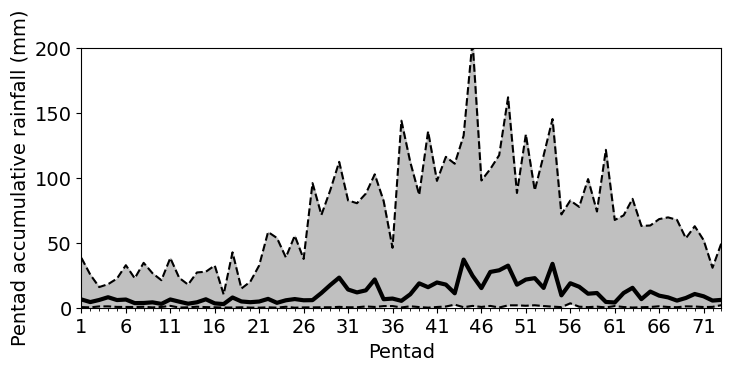

In [2]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

maxl = pcp_max.plot.line(color='black',linestyle='--',
                         x='pentad', xlim=(1,73), ylim=(0,200),
                         ax=ax)
minl = pcp_min.plot.line(color='black',linestyle='--',
                         x='pentad', xlim=(1,73), ylim=(0,200),
                         ax=ax)
medl = pcp_med.plot.line(color='black',linestyle='-', linewidth=3,
                         x='pentad', xlim=(1,73), ylim=(0,200),
                         ax=ax)

ax.fill_between(pcp_ptd.pentad, pcp_max, pcp_min, color='silver')

ax.set_xticks(range(1,75,5))
ax.set_xlabel('Pentad') 
# Set minor ticks 
minor_locator = ticker.IndexLocator(base=1, offset=0)
ax.xaxis.set_minor_locator(minor_locator)

ax.set_ylabel('Pentad accumulative rainfall (mm)')
ax.set_title(" ")

plt.subplots_adjust(left=0.1,bottom=0.15,top=0.8,right=0.9)

plt.show()

```{admonition} Exercise
:class: tip
試著加上任一年份的折線在上圖中，並以藍色粗線來表示。
```


### Twin axes

有時候一張圖上會畫兩種不同的變數，而這兩種變數的量值相差很大時，就需要用twin axis設定兩個不同的y軸 (或x軸)。我們看以下澳洲季風時間序列圖的例子。

**Example 2: 繪製澳洲季風指標時間序列：** 以[Hung and Yanai (2004)](https://rmets.onlinelibrary.wiley.com/doi/10.1256/qj.02.191)的澳洲季風指標為例。

Step 1: 讀入850-hPa緯向風場 (zonal wind) 和OLR資料，選擇時空範圍。

In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 16})

# 設定經緯度範圍。
lats = -15
latn = -2
lon1 = 110
lon2 = 150
plev = 850

# Read data
uds = xr.open_mfdataset( ['data/ncep_r2_uv850/u850.2019.nc', 'data/ncep_r2_uv850/u850.2020.nc'], 
                           combine = "nested",               
                           concat_dim='time',          
                           parallel=True              
                         )
u = uds.sel(time=slice('2019-11-01','2020-03-31'), 
            level=850,
            lat=slice(latn,lats),
            lon=slice(lon1,lon2)).uwnd

with xr.open_dataset("data/olr.nc") as olrds:
     olr = olrds.sel(time=slice('2019-11-01','2020-03-31'),
                         lat=slice(lats,latn),
                         lon=slice(lon1,lon2)).olr



Step 2: 分析與計算，即按照Hung and Yanai (2004) 的定義計算風場和OLR的季風指標，將2˚-15˚S, 110˚-130˚E範圍進行平均。

In [4]:
# 進行空間平均。
u_yh04   =   u.sel(lat=slice(-2,-15), lon=slice(115,150)).mean(axis=(1,2))
olr_yh04 = olr.sel(lat=slice(-15,-2), lon=slice(115,150)).mean(axis=(1,2))

Step 3: 將風場和OLR指標繪製時序圖。然而OLR和風的數值差異很大，所以需要設定兩個繪圖空間`ax1`和`ax2`，其中繪圖空間`ax1`畫850-hPa緯向風，繪圖空間`ax2`畫OLR，`ax1`和`ax2`共用x軸，y軸顯示的方式則是風在左側、OLR在右側。兩個繪圖空間共用x軸可以用`matplotlib.axes.Axes.twinx()`來設定。

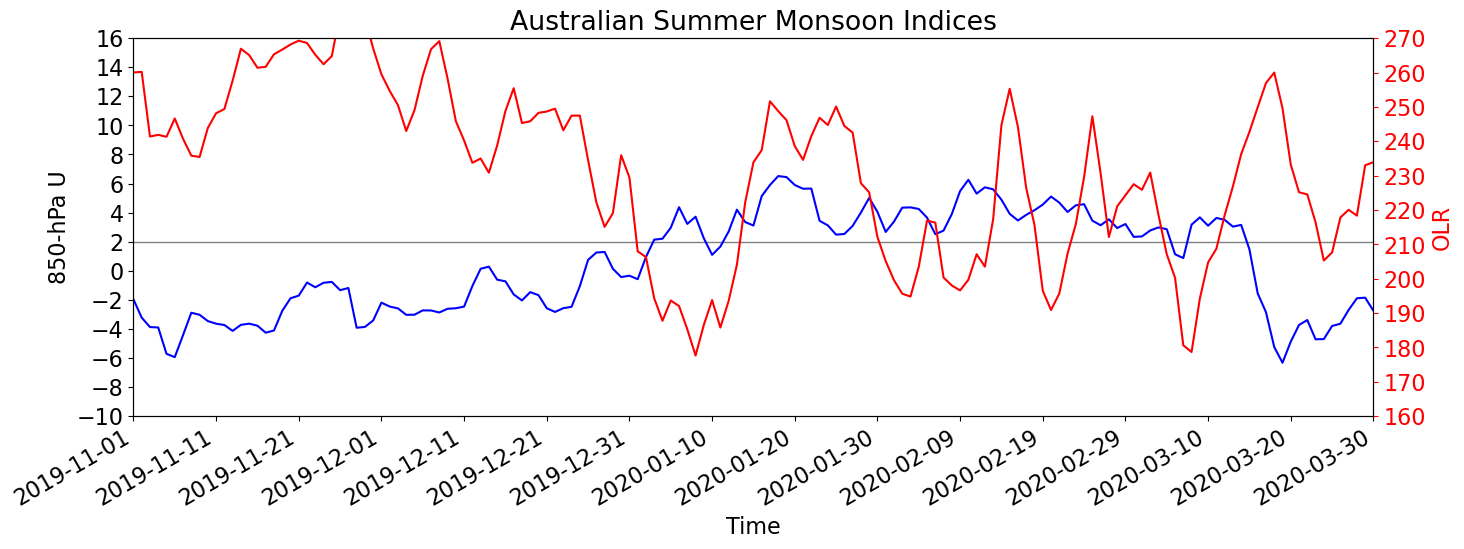

In [5]:
# 繪圖
fig, ax1 = plt.subplots(figsize=(16,6))    # 開啟fig畫布，以及繪圖空間ax1。
# Duplicate the axes with a different y axis and the same x axis
ax2 = ax1.twinx()  
# 加入 Uyh04 = 2 m/s 橫線，為YH04指標的門檻。
ax1.axhline(y=2,linewidth=1,color='gray')
xticks = pd.date_range("2019-11-01", periods=16, freq="10D")

# 時序圖繪製：ax1是風指標的繪圖空間，ax2是OLR指標的繪圖空間，要在xarray.plot.line的ax引數中指定。
u_yh04_plot = u_yh04.plot.line(u_yh04, color='blue',
                               x='time',xlim=(xticks[0],xticks[-1]),xticks=xticks,
                               ylim=(-10,16) ,ax=ax1)
olr_plot = olr_yh04.plot.line(olr_yh04,color='red',
                              x='time',xlim=(xticks[0],xticks[-1]),xticks=xticks,
                              ylim=(160,270),ax=ax2)

# 設定x、y軸名稱、顏色。
ax1.set_ylabel("850-hPa U", color='black')
ax2.set_ylabel("OLR"      , color='red'  )
ax1.set_xlabel("Time") # ax2 has no property control over x axis

# 設定y軸數值。
ax1.set_yticks(range(-10,18,2))
ax2.set_yticks(range(160,280,10))
ax1.tick_params(axis='y', colors='black')
ax2.tick_params(axis='y', colors='red'  )
ax2.yaxis.label.set_color('red')

# set x ticks
ax1.set_xticks(xticks)
ax1.set_title('Australian Summer Monsoon Indices')

plt.subplots_adjust(bottom=0.25)

plt.show()
